In [1]:
#%% Atividade nº 4 - Dataset Jogos da Copa do Mundo de Futebol 2022

# As observações são os jogos que aconteceram ao longo da Copa
# Fonte: https://www.kaggle.com/datasets/mcarujo/fifa-world-cup-2022-catar?select=matches_world_cup_2022_catar.csv


In [2]:
#%% Carregando os pacotes

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#%% Importando o banco de dados

dados_jogos = pd.read_csv('4.2_Jogos_Copa_22.csv', sep=',')

In [4]:
#%% Informações básicas do dataset

dados_jogos.info()

# O dataset já está bastante organizado!


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   match_id                  64 non-null     int64  
 1   stage                     64 non-null     object 
 2   date                      64 non-null     object 
 3   pens                      64 non-null     bool   
 4   pens_home_score           64 non-null     object 
 5   pens_away_score           64 non-null     object 
 6   team_name_home            64 non-null     object 
 7   team_name_away            64 non-null     object 
 8   team_home_score           64 non-null     int64  
 9   team_away_score           64 non-null     int64  
 10  possession_home           64 non-null     float64
 11  possession_away           64 non-null     float64
 12  total_shots_home          64 non-null     int64  
 13  total_shots_away          64 non-null     int64  
 14  shots_on_tar

In [5]:
#%% Criando uma variável com o time vencedor do jogo

# Uma variável que não consta na lista é o time vencedor do jogo

dados_jogos['venceu'] = np.where((dados_jogos['team_home_score'] - dados_jogos['team_away_score'] > 0), 'mandante',
                        np.where((dados_jogos['team_home_score'] - dados_jogos['team_away_score'] < 0), 'visitante',
                        np.where((dados_jogos['team_home_score'] - dados_jogos['team_away_score'] == 0), 'empate',
                                "Demais")))

# Entretanto, algumas partidas foram decididas nos pênaltis
# Vamos incorporar tais variáveis às análises

In [6]:
#%% Ajustando classe das variáveis de pênaltis

# Note que estão como textos, precisam ser numéricas

# Primeiramente, substituir os textos Falses por NAs
dados_jogos['pens_home_score'] = dados_jogos['pens_home_score'].replace('False', np.nan)
dados_jogos['pens_away_score'] = dados_jogos['pens_away_score'].replace('False', np.nan)

# Em seguida, convertendo para variáveis numéricas
dados_jogos['pens_home_score'] = dados_jogos['pens_home_score'].astype('float')
dados_jogos['pens_away_score'] = dados_jogos['pens_away_score'].astype('float')


In [7]:
#%% Ajustando a variável com o time vencedor do jogo

dados_jogos['vencedor'] = np.where(dados_jogos['pens_home_score'] - dados_jogos['pens_away_score'] > 0, 'mandante',
                          np.where(dados_jogos['pens_home_score'] - dados_jogos['pens_away_score'] < 0, 'visitante',
                          np.where(dados_jogos['pens_home_score'].isna(), dados_jogos['venceu'],
                                   "Demais")))

# E eliminando a variável base anterior
dados_jogos.drop(columns=['venceu'], inplace=True)

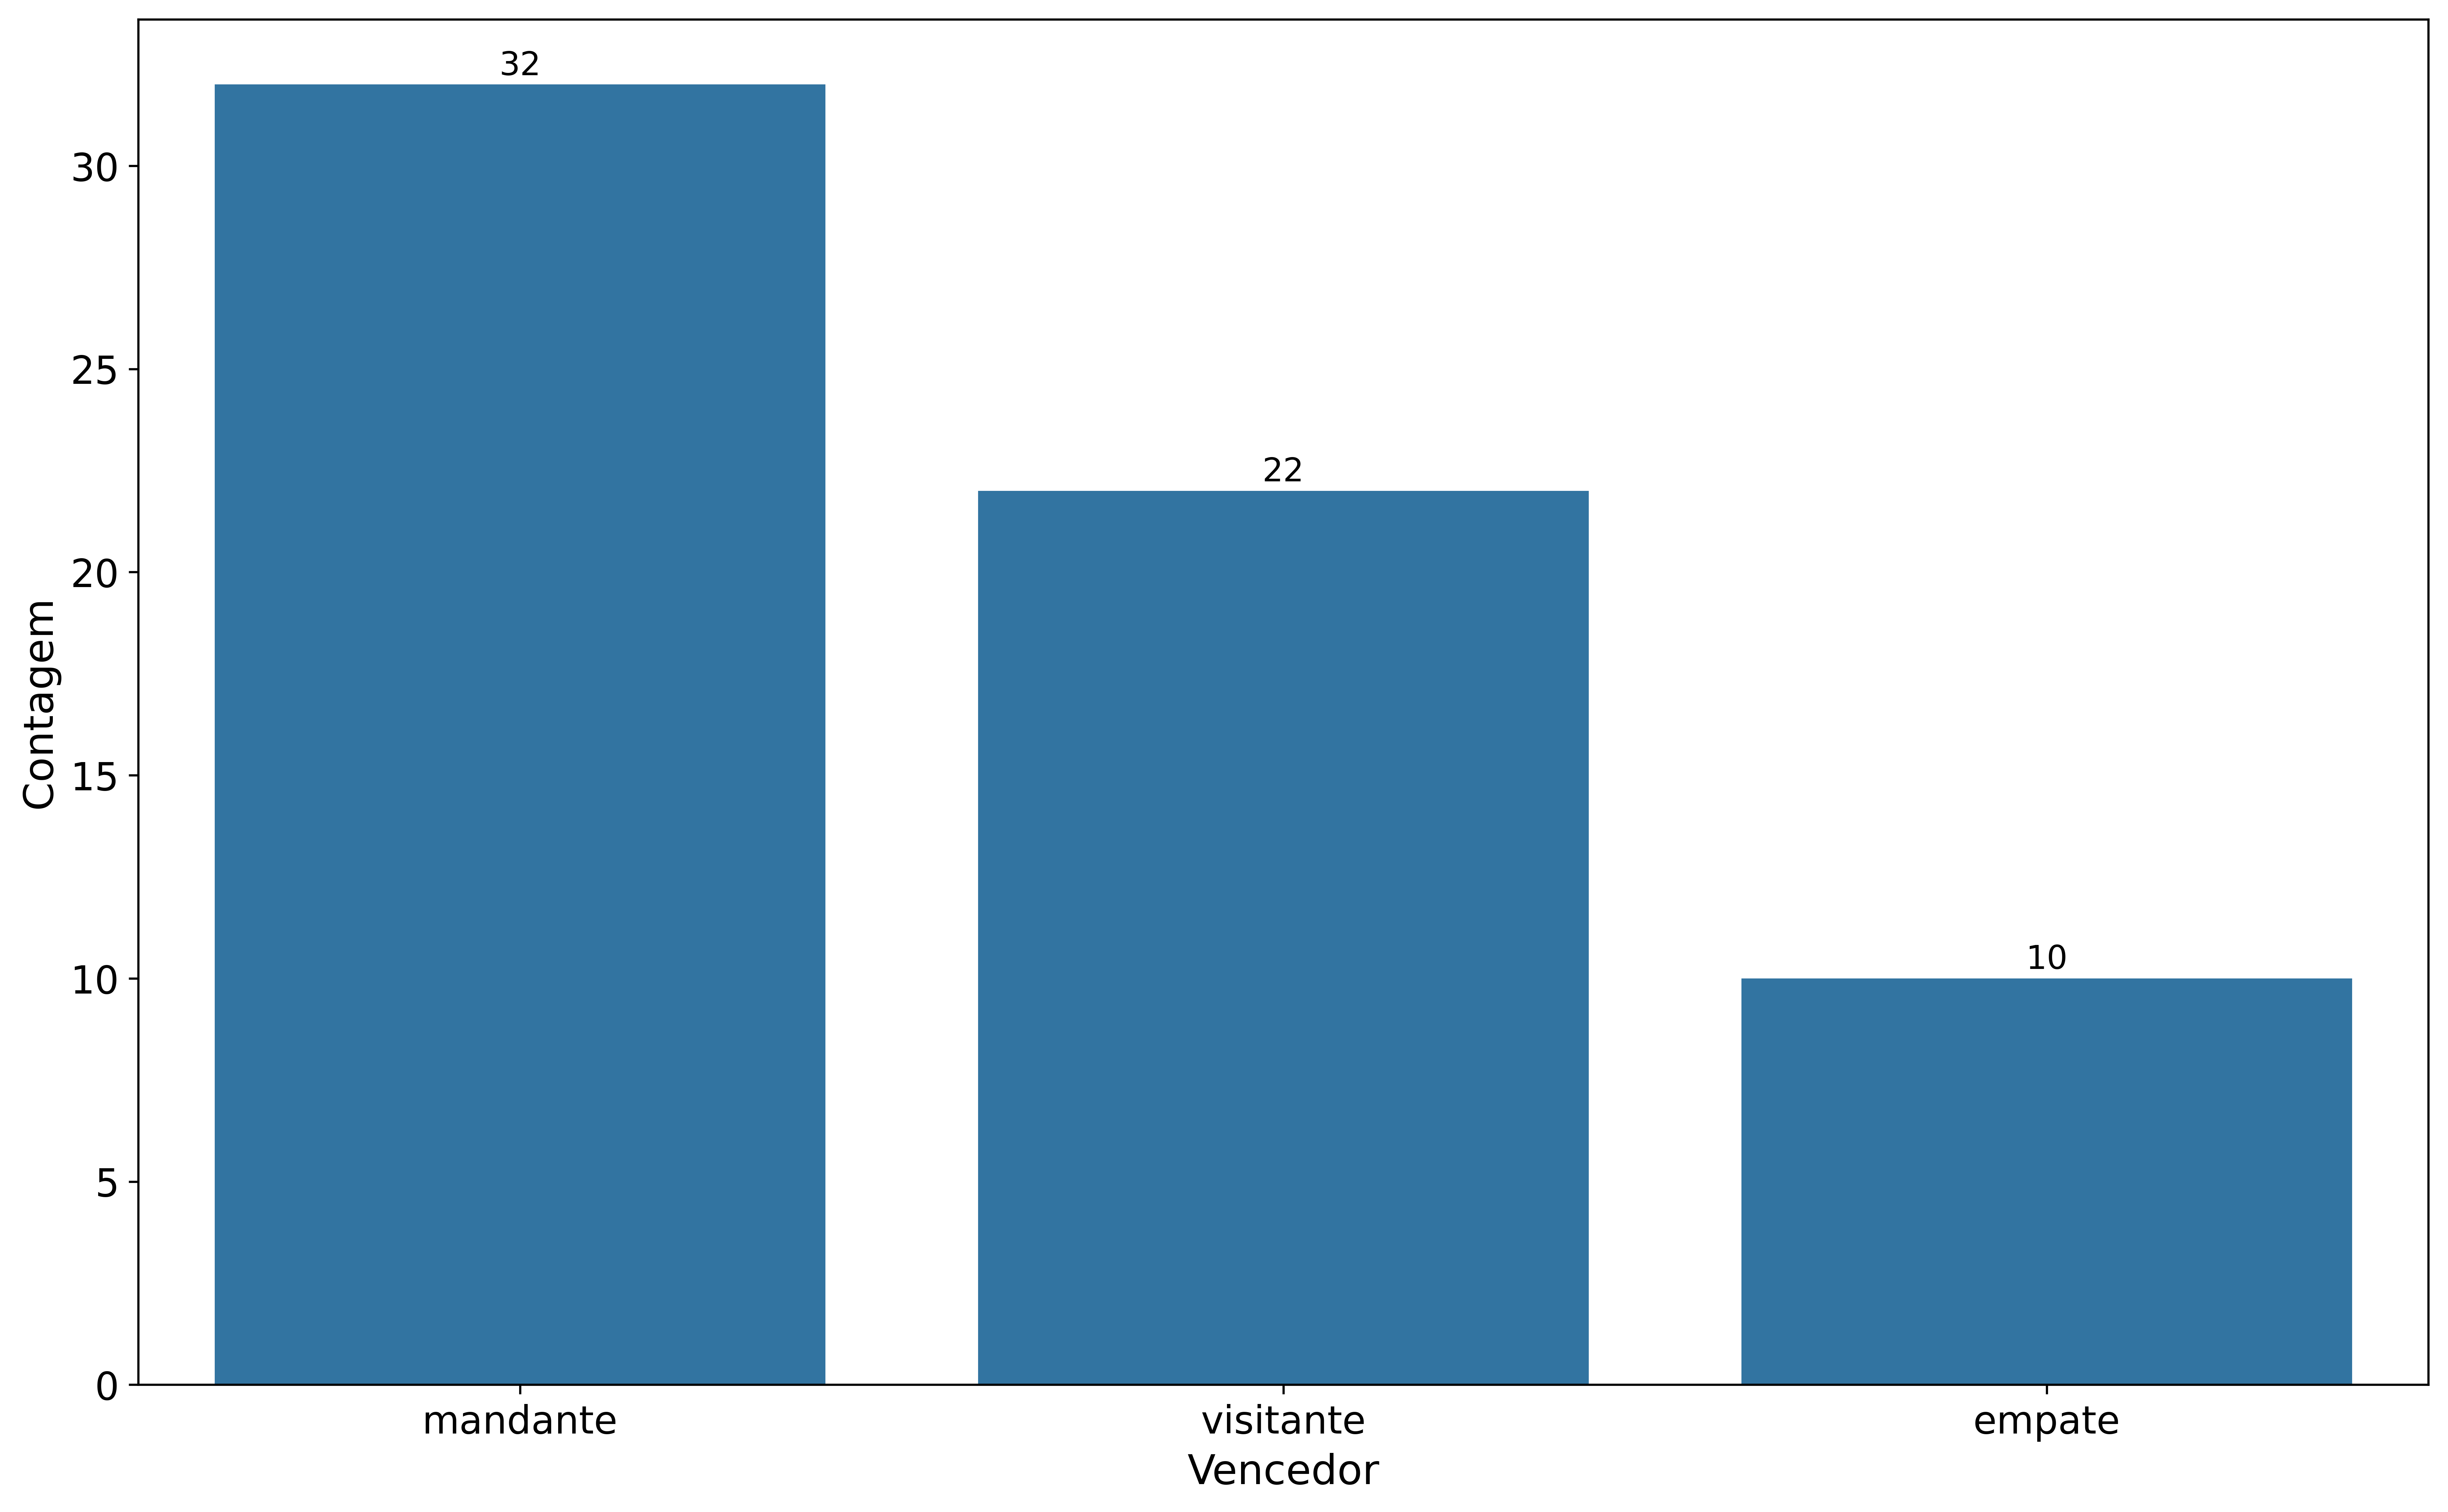

In [8]:
#%% Informações sobre os vencedores

# Tabela de frequências
dados_jogos['vencedor'].value_counts()

# Gerando um gráfico com as informações dos vencedores
plt.figure(figsize=(15,9), dpi = 600)
ax=sns.countplot(x=dados_jogos['vencedor'])
for container in ax.containers: ax.bar_label(container, padding=1, fontsize=12)
plt.xlabel('Vencedor',fontsize=15)
plt.ylabel('Contagem',fontsize=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [9]:
#%% Identificando a fase da competição

# Vamos obter a primeira palavra da variável 'stage'
dados_jogos['fase'] = dados_jogos['stage'].str.split(' ').str[0]

In [10]:
#%% Vencedores por fase da competição

dados_jogos.groupby(['fase'])['vencedor'].value_counts()


fase            vencedor 
Final           mandante      1
Group           mandante     19
                visitante    19
                empate       10
Match           mandante      1
Quarter-finals  mandante      2
                visitante     2
Round           mandante      7
                visitante     1
Semi-finals     mandante      2
Name: count, dtype: int64

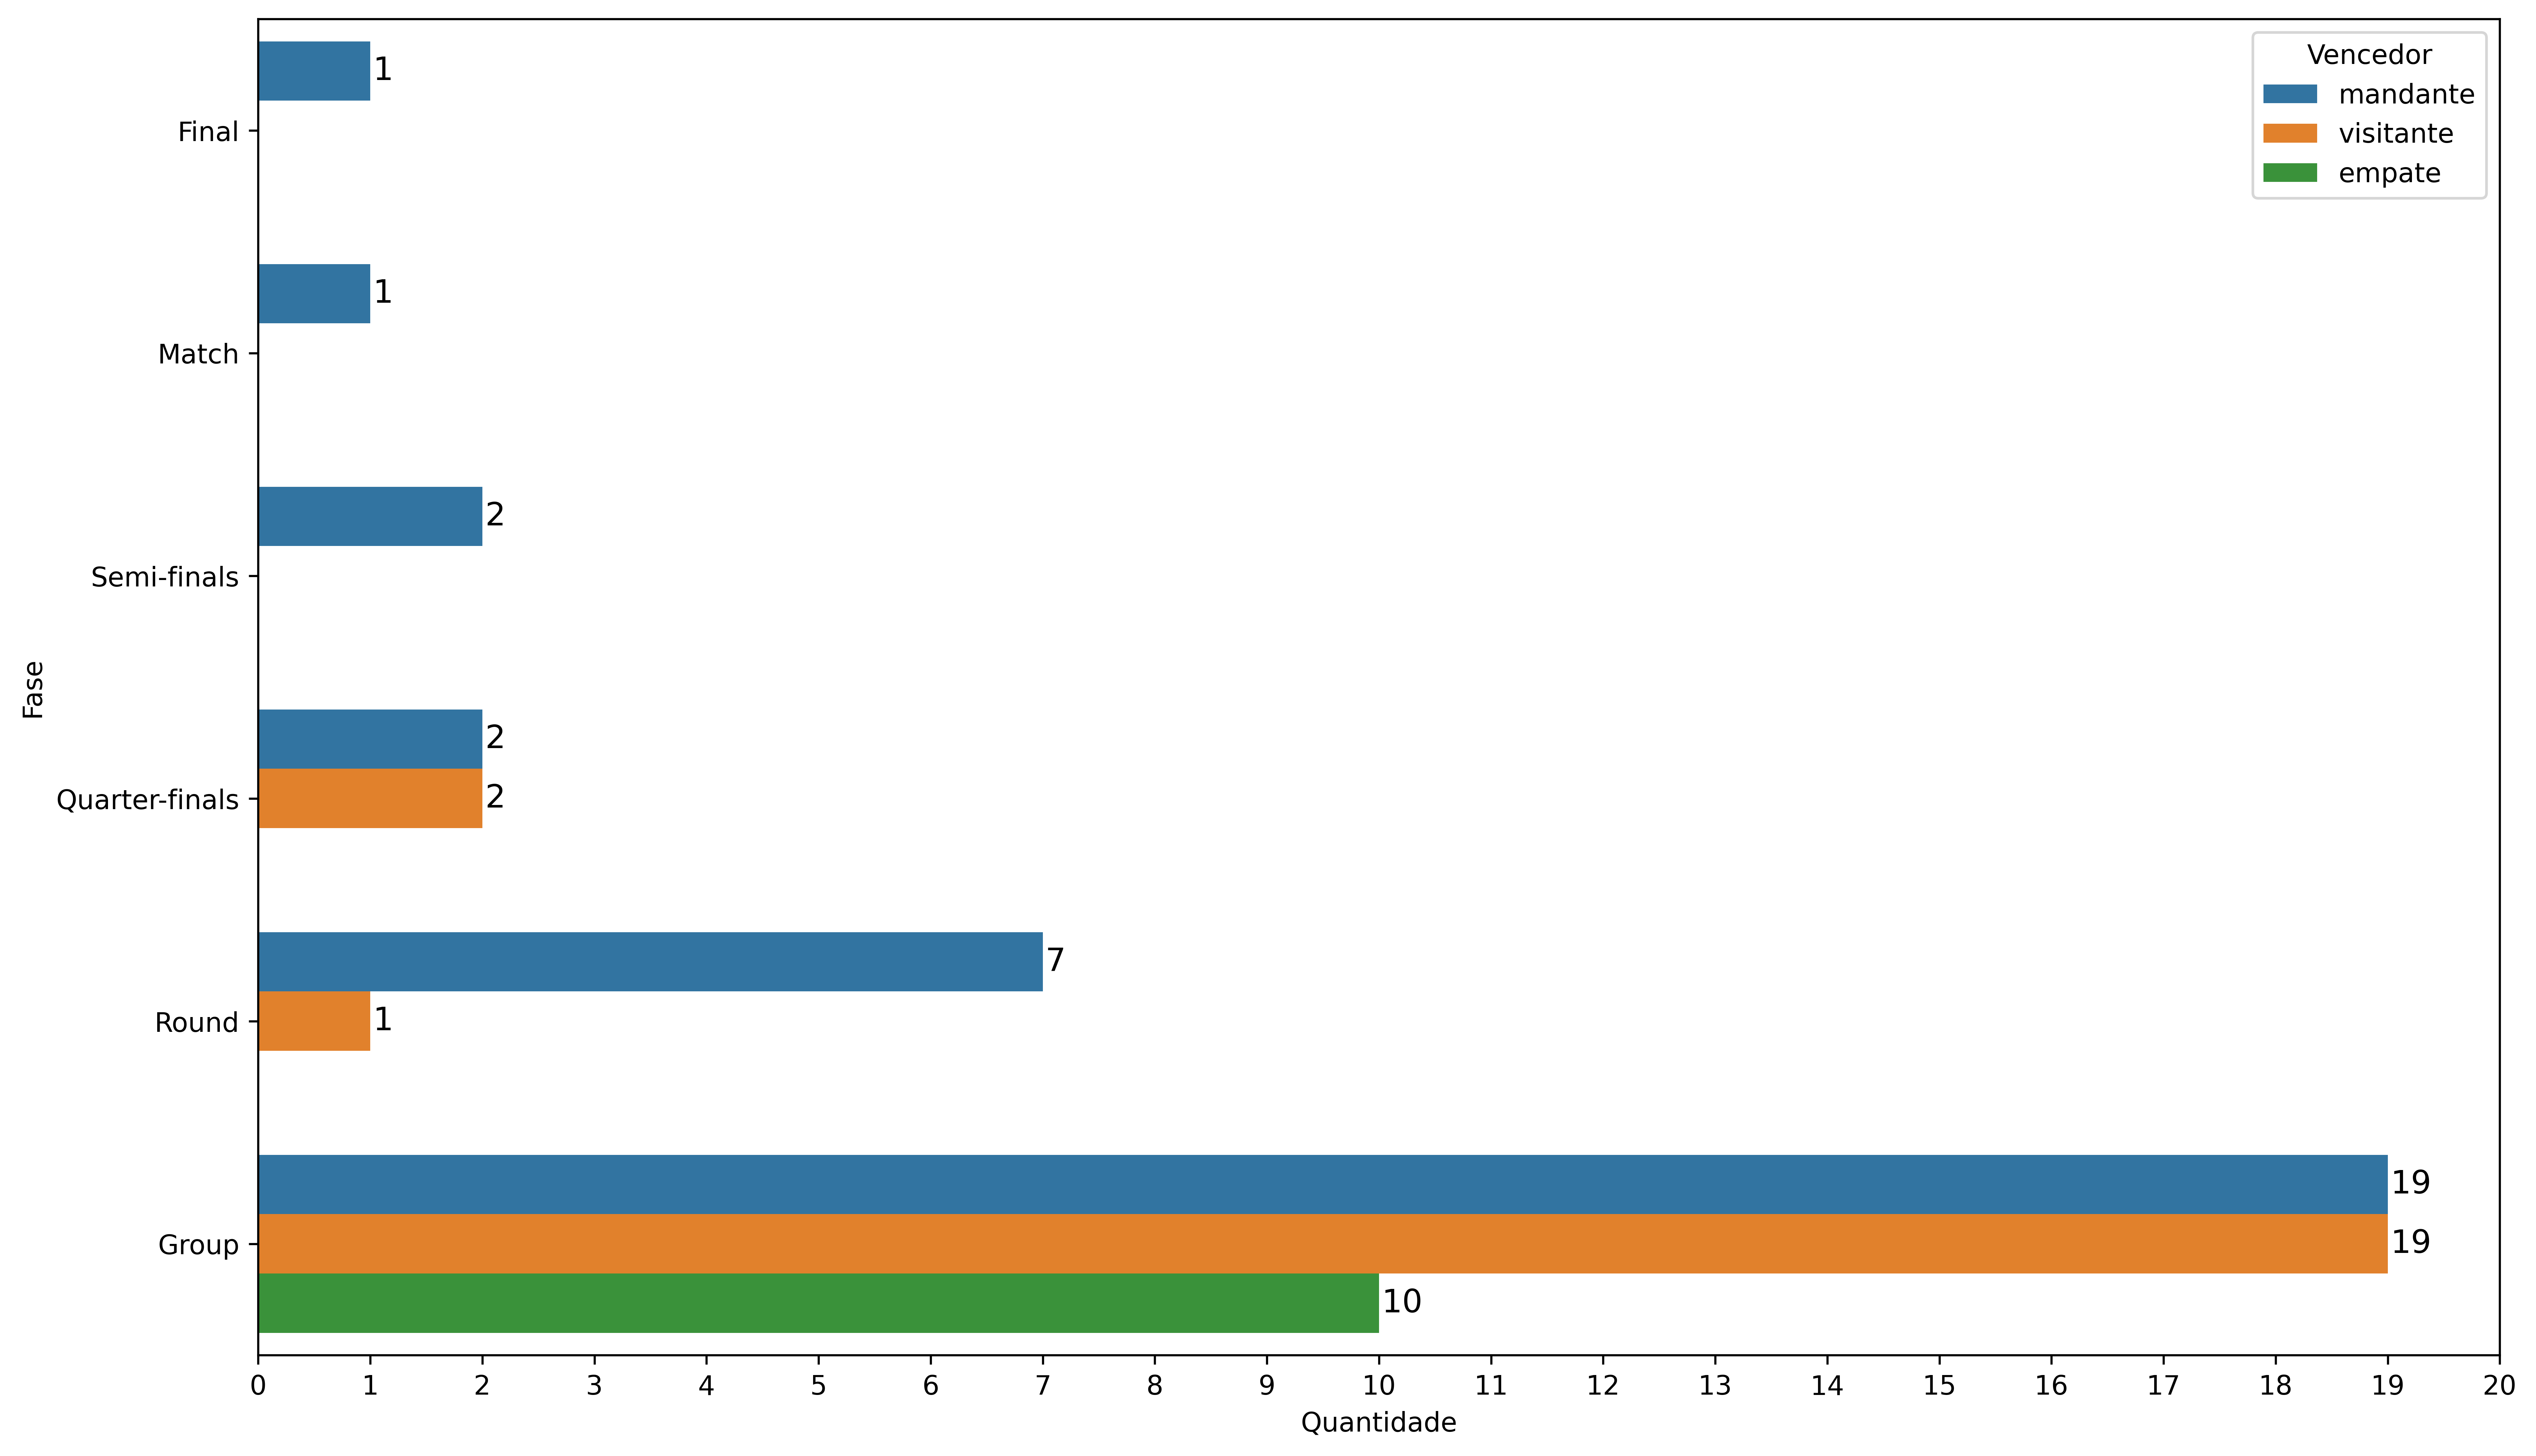

In [11]:
#%% Gerando um gráfico com as informações dos vencedores por fase

plt.figure(figsize=(15,9), dpi = 600)
ax1=sns.countplot(data=dados_jogos, y='fase', hue='vencedor')
for container in ax1.containers: ax1.bar_label(container, padding=1, fontsize=12)
plt.legend(loc='upper right', title='Vencedor')
plt.xlabel('Quantidade')
plt.ylabel('Fase')
plt.xticks(np.arange(0, 21, step=1))
plt.show()

In [12]:
#%% No dataset há informações com as probabilidades de vitórias das seleções

# Vamos analisar se os modelos estavam certos ou não!

# Gerando a categorização
dados_jogos['previsao'] = np.where(dados_jogos['prediction_team_home_win'] > dados_jogos['prediction_team_away_win'], 'mandante',
                          np.where(dados_jogos['prediction_team_home_win'] < dados_jogos['prediction_team_away_win'], 'visitante',
                                   'Demais'))

# Comparando com o realizado
dados_jogos['result_previsao'] = np.where(dados_jogos['vencedor'] == dados_jogos['previsao'], 'acerto',
                                 np.where(dados_jogos['vencedor'] != dados_jogos['previsao'], 'erro',
                                          'Demais'))

dados_jogos['result_previsao'].value_counts(normalize=True)

result_previsao
acerto    0.578125
erro      0.421875
Name: proportion, dtype: float64

In [13]:
#%% Vamos analisar os jogadores que fizeram gols

# Esta informação está na variável "events_list" que é uma string mais complexa
# Precisamos retirar a informação específica, então vamos procurar um padrão
# A informação que queremos está após 'Goal', 'action_player_1': '

# Extraindo os jogadores que fizeram gols

extrai_gol = dados_jogos['events_list'].str.extractall("'Goal', 'action_player_1': '\\w*(.*?)\\w*\\'")

# Acima, utilizamos regex (regular expression), úteis para trabalhar em strings
# É importante conhecer a existência delas, em alguns casos podem ajudar
# O str.extractall pede para extrair em todas as ocorrências do padrão

# Extraindo também os jogadores que fizeram gols de pênaltis

extrai_penalti = dados_jogos['events_list'].str.extractall("'event_type': 'Penalty', 'action_player_1': '\\w*(.*?)\\w*\\'")


In [14]:
#%% Unindo os datasets

gols = pd.concat([extrai_gol, extrai_penalti], ignore_index=True)

tabela_artil = gols.value_counts()

#%% FIM!